In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import copy

# --- CONFIGURATION ---
config = {
    'data_path': r'dataset_split/',
    'model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'batch_size': 16,
    'img_size': 224,
    'weight_decay': 0.01,
    'epochs': 80,
    'num_workers': 3,
    'pin_memory': True,
    'patience': 12,
    'drop_rate': 0.4,
    'drop_path_rate': 0.2,
    'head_lr': 1e-3,
    'head_epochs': 10,
    'full_train_lr': 5e-5,
    'lr_warmup_epochs': 5,
    'label_smoothing': 0.1,
}

In [2]:
# --- DATA PREPARATION, TRAINING, AND VALIDATION FUNCTIONS ---

def get_data_loaders(data_path, img_size, batch_size, num_workers, pin_memory):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    train_dataset = datasets.ImageFolder(root=os.path.join(data_path, 'train'), transform=train_transform)
    val_dataset = datasets.ImageFolder(root=os.path.join(data_path, 'val'), transform=val_test_transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(data_path, 'test'), transform=val_test_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    class_names = train_dataset.classes
    print(f"Found classes: {class_names}")
    return train_loader, val_loader, test_loader, class_names

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
    acc = correct_predictions.double() / len(dataloader.dataset)
    return running_loss / len(dataloader.dataset), acc.item()

print("✅ Helper functions are defined.")

✅ Helper functions are defined.


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
train_loader, val_loader, test_loader, class_names = get_data_loaders(
    config['data_path'], config['img_size'], config['batch_size'], config['num_workers'], config['pin_memory']
)
num_classes = len(class_names)

# Load model
model = timm.create_model(
    config['model_name'], pretrained=True, num_classes=num_classes,
    drop_rate=config['drop_rate'], drop_path_rate=config['drop_path_rate']
)
model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

print("\n✅ Model and data are ready for training!")

Using device: cuda
Found classes: ['Alapadmam(1)', 'Aralam(1)', 'Ardhachandran(1)', 'Ardhapathaka(1)', 'Bramaram(1)', 'Chandrakala(1)', 'Chaturam(1)', 'Hamsapaksha(1)', 'Hamsasyam(1)', 'Kangulam(1)', 'Kapith(1)', 'Katakamukha_1', 'Katakamukha_2', 'Katakamukha_3', 'Katrimukha(1)', 'Mayura(1)', 'Mrigasirsha(1)', 'Mukulam(1)', 'Mushti(1)', 'Padmakosha(1)', 'Pathaka(1)', 'Sarpasirsha(1)', 'Shukatundam(1)', 'Sikharam(1)', 'Simhamukham(1)', 'Suchi(1)', 'Tamarachudam(1)', 'Tripathaka(1)', 'Trishulam(1)']

✅ Model and data are ready for training!



--- Evaluating on Test Set ---


Testing: 100%|██████████| 76/76 [00:08<00:00,  9.07it/s]



Final Test Accuracy: 97.94%

Classification Report:
                  precision    recall  f1-score   support

    Alapadmam(1)       0.98      0.96      0.97        46
       Aralam(1)       1.00      1.00      1.00        41
Ardhachandran(1)       1.00      0.97      0.98        30
 Ardhapathaka(1)       0.82      0.97      0.89        37
     Bramaram(1)       1.00      1.00      1.00        30
  Chandrakala(1)       1.00      0.95      0.97        38
     Chaturam(1)       0.94      1.00      0.97        31
  Hamsapaksha(1)       0.96      1.00      0.98        48
    Hamsasyam(1)       0.98      1.00      0.99        56
     Kangulam(1)       1.00      1.00      1.00        53
       Kapith(1)       1.00      1.00      1.00        43
   Katakamukha_1       1.00      1.00      1.00        39
   Katakamukha_2       1.00      0.97      0.99        35
   Katakamukha_3       1.00      1.00      1.00        40
   Katrimukha(1)       1.00      1.00      1.00        45
       Mayura(1)  

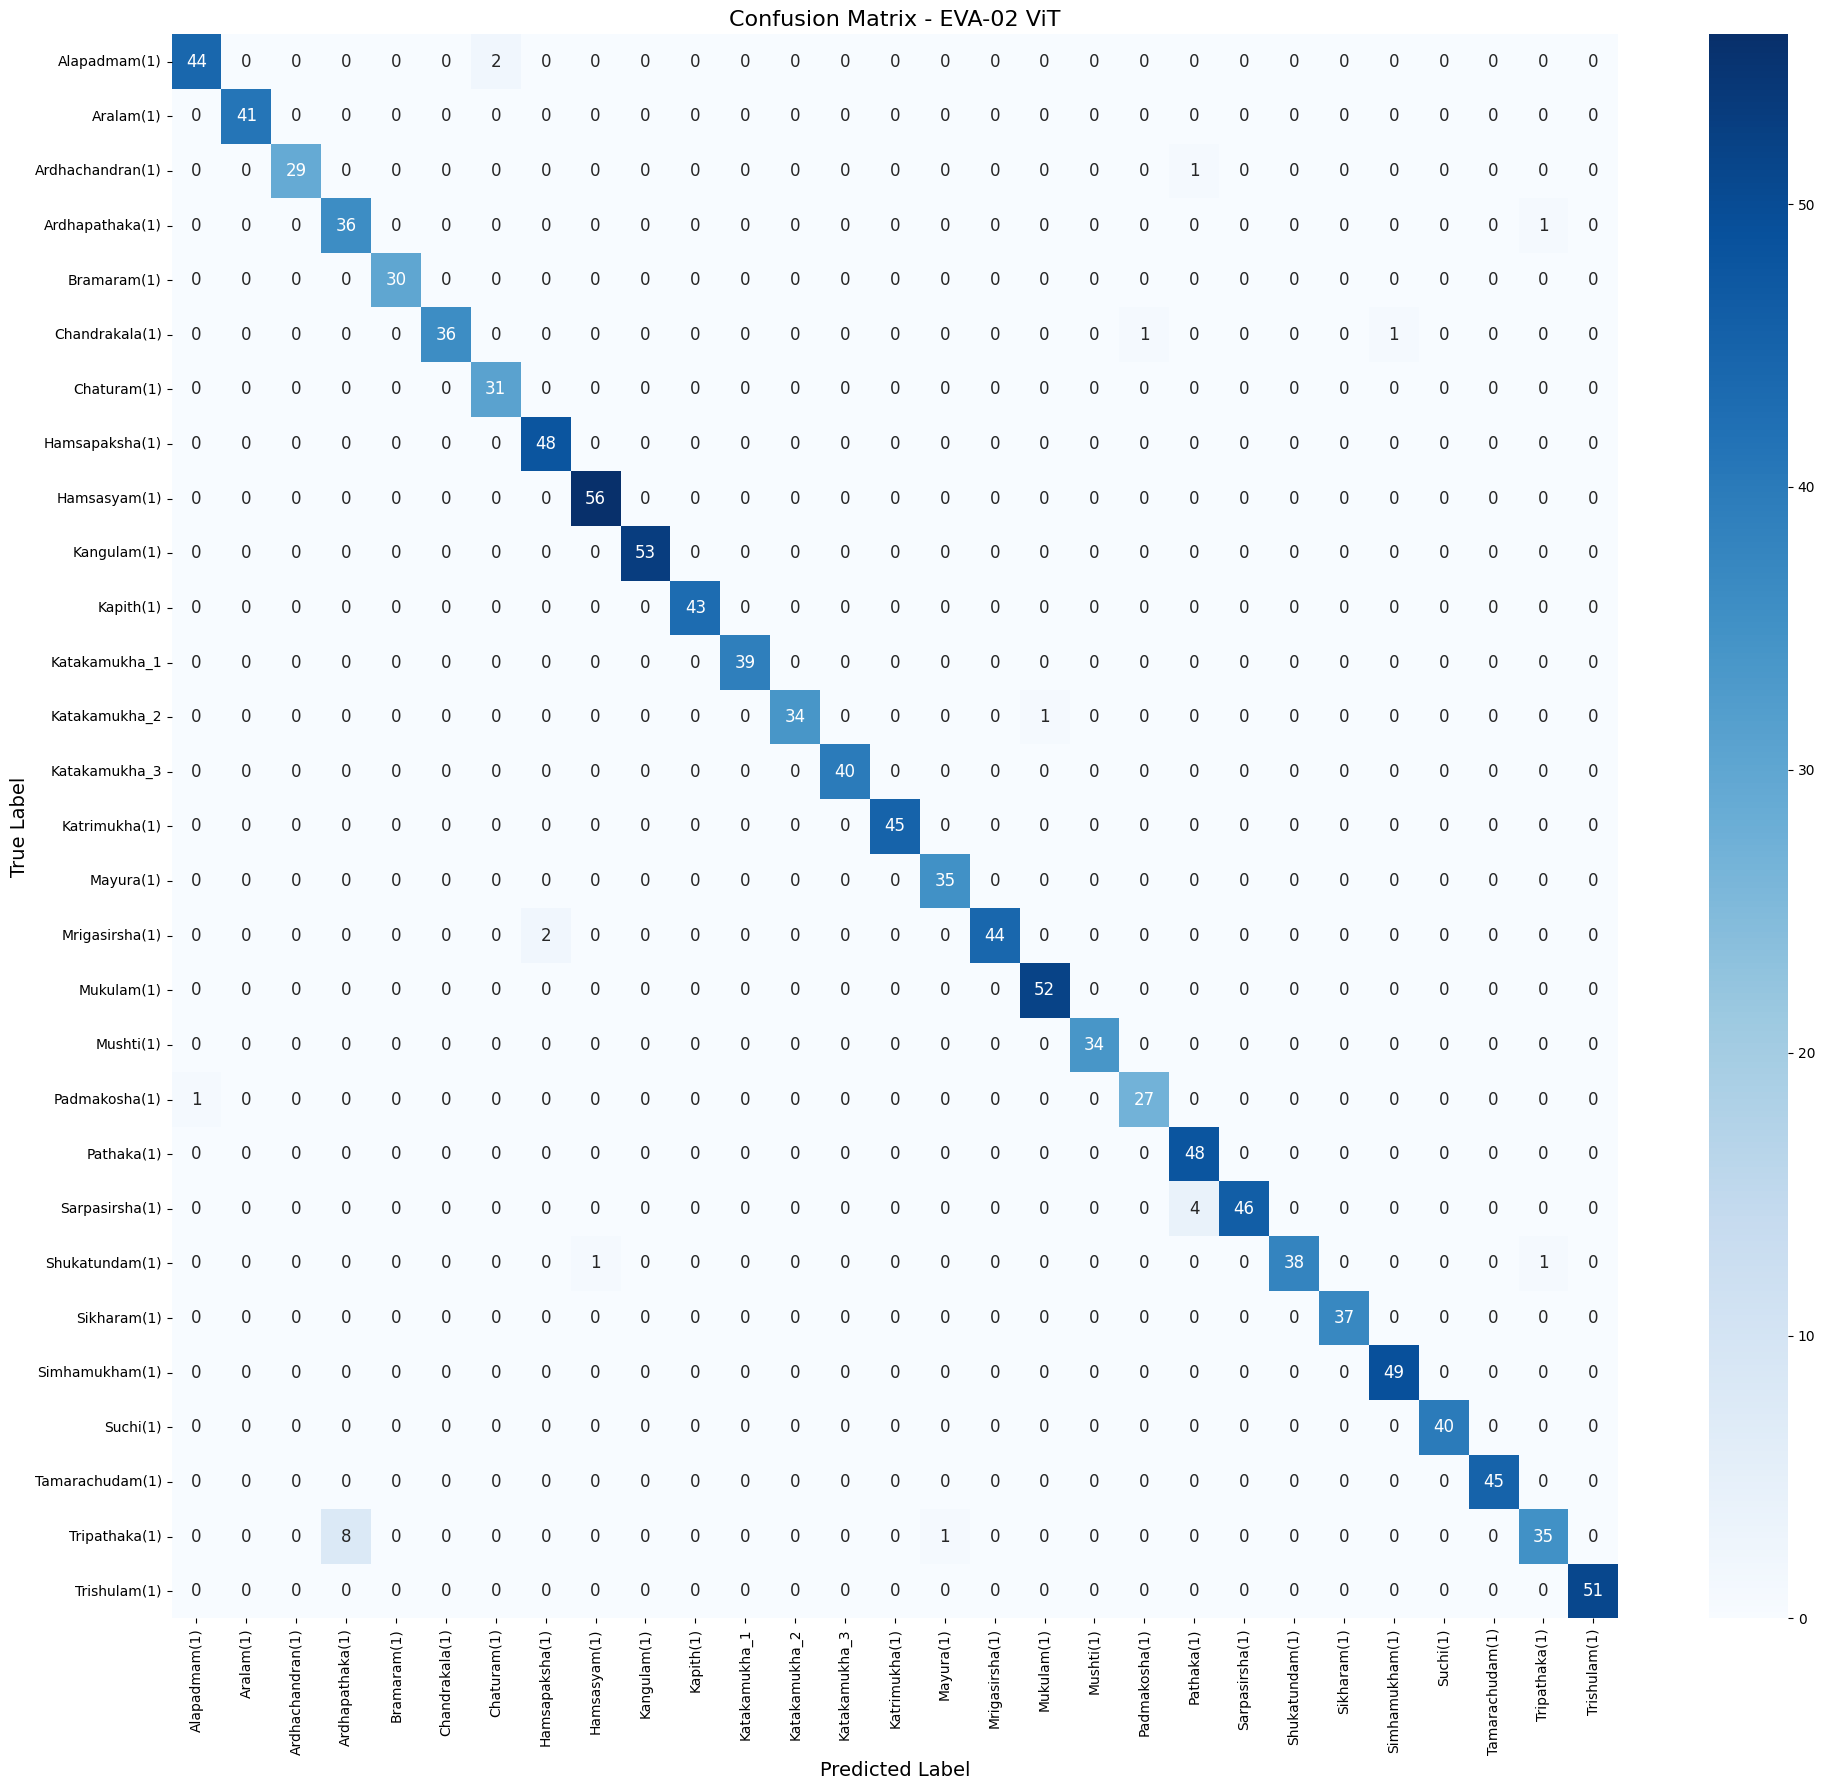

In [4]:
# --- FINAL EVALUATION ON TEST SET (WITH IMPROVED PLOTTING) ---
print("\n--- Evaluating on Test Set ---")

# Create a new instance of the model architecture
evaluation_model = timm.create_model(
    config['model_name'], pretrained=False, num_classes=num_classes
)
# Load the best weights saved during training
evaluation_model.load_state_dict(torch.load('best_model.pth'))
evaluation_model.to(device)
evaluation_model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = evaluation_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(f"\nFinal Test Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# --- Generate Improved Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

# Create a much larger figure to give space for labels
plt.figure(figsize=(20, 18))

# Use Seaborn's heatmap with customizations
sns.heatmap(
    cm, 
    annot=True,          # Show the numbers in the cells
    fmt='d',             # Format as integers
    cmap='Blues',        # Color scheme
    xticklabels=class_names, 
    yticklabels=class_names,
    annot_kws={"size": 12} # Set the font size for the numbers
)

# Rotate labels for better readability
plt.xticks(rotation=90) # Rotate x-axis labels (Predicted)
plt.yticks(rotation=0)  # Keep y-axis labels horizontal (True)

# Add titles and labels
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix - EVA-02 ViT', fontsize=16)

# Use tight_layout to ensure everything fits without overlapping
plt.tight_layout()

# Save the high-quality figure
plt.savefig('confusion_matrix_eva02_improved.png', dpi=300)
print("\nImproved confusion matrix saved to confusion_matrix_eva02_improved.png")
plt.show()